# [S24] Introduction to Machine Learning: Bonus assignment
**Student name:** <font color='red'>Liana Mardanova</font>

**Student email:** <font color='red'>l.mardanova@innopolis.university</font>

## Task 1. Baseline model [0pt]

Training done in Assignment 2. Model saved to "LianaMardanova.pt".

In [ ]:
# Import nessesary libraries
import torch
import os
from torch.utils import data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from time import time
from tqdm import tqdm
from torch.optim import SGD, Adam
from torch.optim import lr_scheduler
import pickle
import torch
import copy
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
from sklearn.metrics import accuracy_score, roc_auc_score
import time

In [ ]:
# Define device based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [ ]:
# Custom model class from assignment 2
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout(p=0.1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=32),
            nn.Dropout(p=0.15)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.Dropout(p=0.2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.Dropout(p=0.25)
        )
        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=128 * 2 * 2, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=512),
            nn.Dropout(p=0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=256),
            nn.Dropout(p=0.4)
        )
        self.fc3 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)  # Using log softmax activation for output probabilities

# Create an instance of the CustomModel and move it to the selected device
custom_model = CustomModel().to(device)
print(custom_model)

CustomModel(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.15, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.2, inplace=False)
 

In [ ]:
# Loading trained model from file
custom_model_path = "LianaMardanova.pt"
model_state_dict = torch.load(custom_model_path, map_location=device)
custom_model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [ ]:
# Define transformations for test data
test_transforms_for_custom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalize the image with mean and standard deviation (as for pretrained model in next part)
])

batch_size = 128
# Load CIFAR-10 datasets for testing
test_dataset_for_custom = datasets.CIFAR10(root='cifar10',
                                train=False,
                                transform=test_transforms_for_custom,
                                download=True)

# Create data loaders for testing datasets
test_data_loader_for_custom = data.DataLoader(test_dataset_for_custom,
                                   batch_size=batch_size,
                                   shuffle=False)

Files already downloaded and verified


In [ ]:
# Modified function for testing from Lab10
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  * data.size(0)
            total_samples += data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(test_loader.dataset)
    test_loss = test_loss / total_samples
    return test_loss, acc

In [ ]:
# Calculate loss and accuracy of baseline model
criterion = nn.CrossEntropyLoss()
test_loss, accuracy = test(custom_model, device, test_data_loader_for_custom, criterion)
print(f"Test loss: {test_loss}, Accuracy: {accuracy}")

Test loss: 0.6644567056655883, Accuracy: 76.44


## Task 2. Self-supervised learning [12pts]

### Part for autoencoder model

In [ ]:
# Define transformations for training and test data
train_transforms_for_autoencoder = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(45, shear=7, scale=(0.7, 1.3)),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize the image with mean and standard deviation (as in task 2 in assignment 2)
])

test_transforms_for_autoencoder = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalize the image with mean and standard deviation (as in task 2 in assignment 2)
])

In [ ]:
batch_size = 64
# Load CIFAR-10 datasets for both training and testing
train_dataset_for_autoencoder = datasets.CIFAR10(root='cifar10',
                                                 train=True,
                                                 transform=train_transforms_for_autoencoder,
                                                 download=True)

test_dataset_for_autoencoder = datasets.CIFAR10(root='cifar10',
                                                train=False,
                                                transform=test_transforms_for_autoencoder,
                                                download=True)

# Create data loaders for training and testing datasets
train_data_loader_for_autoencoder = data.DataLoader(train_dataset_for_autoencoder,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    drop_last=True)

test_data_loader_for_autoencoder = data.DataLoader(test_dataset_for_autoencoder,
                                                   batch_size=batch_size,
                                                   shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define the Autoencoder model (Updated version of model from https://stackoverflow.com/questions/69193892/autoencoder-for-cifar-10-with-low-accuracy)
class AutoencoderModel(nn.Module):
    def __init__(self):
        super(AutoencoderModel, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create an instance of the AutoencoderModel and move it to the selected device
autoencoder_model = AutoencoderModel().to(device)
print(autoencoder_model)

AutoencoderModel(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
# Same EarlyStopping class as in Assignment 2 (Task2) (Class from https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py designed to implement early stopping functionality during training process)
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
# Modified functions from Lab 10 used for train and test
def autoencoder_train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    total_samples = 0

    bar = tqdm(train_loader)
    for data, _ in bar:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * data.size(0)
        total_samples += data.size(0)

        bar.set_postfix({"Loss": format(epoch_loss/total_samples, '.6f')})

    print(f'\nTrain Epoch: {epoch}, elapsed time:{time()-start_time:.2f}s')
    return epoch_loss / total_samples


def autoencoder_test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    total_samples = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = model(data)
            test_loss += criterion(output, data).item() * data.size(0)
            total_samples += data.size(0)

    return test_loss / total_samples

In [ ]:
# Modified function from Lab 10 used for training
def autoencoder_training(model, train_data_loader, test_data_loader, epochs, criterion, optimizer, early_stopping, device, save_path, train_info_path):
    # Check if model already exists
    if save_path and os.path.exists(save_path):
        print(f"File already exists at {save_path}. Model not trained, loaded from file.")
        model_state_dict = torch.load(save_path, map_location=device)
        model.load_state_dict(model_state_dict)

        # Load training information from file
        with open(train_info_path, 'rb') as info_file:
            train_losses, test_losses = pickle.load(info_file)

        return train_losses, test_losses

    train_losses, test_losses = [], []

    for epoch in range(1, epochs + 1):
        train_loss = autoencoder_train(model, device, train_data_loader, criterion, optimizer, epoch)
        test_loss = autoencoder_test(model, device, test_data_loader, criterion)
        # Terminate training if loss stopped to decrease
        if early_stopping(test_loss, model):
            print('\nEarly stopping\n')
            break
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"Training loss {train_loss}, test loss {test_loss}\n")

    with open(train_info_path, 'wb') as info_file:
        pickle.dump([train_losses, test_losses], info_file)

    return train_losses, test_losses

In [ ]:
# Defining parameters for training
autoencoder_model_path = "autoencoder_model.pt"
train_info_path_for_autoencoder = "train_info_path_for_autoencoder.pkl"
epochs = 100
criterion = nn.MSELoss()
optimizer = Adam(autoencoder_model.parameters())
early_stopping = EarlyStopping(patience=5, delta=0.001, path=autoencoder_model_path)

# Training model
train_losses, test_losses = autoencoder_training(autoencoder_model, train_data_loader_for_autoencoder, test_data_loader_for_autoencoder, epochs, criterion, optimizer, early_stopping, device, autoencoder_model_path, train_info_path_for_autoencoder)

100%|██████████| 781/781 [01:06<00:00, 11.76it/s, Loss=1.585928]



Train Epoch: 1, elapsed time:66.39s
Training loss 1.585420647125244, test loss 0.6391498038291931



100%|██████████| 781/781 [01:06<00:00, 11.77it/s, Loss=1.567977]



Train Epoch: 2, elapsed time:66.37s
Training loss 1.567475274658203, test loss 0.6334114764213562



100%|██████████| 781/781 [01:05<00:00, 11.85it/s, Loss=1.562081]



Train Epoch: 3, elapsed time:65.89s
Training loss 1.5615808352661134, test loss 0.6307581401824951



100%|██████████| 781/781 [00:58<00:00, 13.35it/s, Loss=1.560131]



Train Epoch: 4, elapsed time:58.52s
EarlyStopping counter: 1 out of 5
Training loss 1.5596322338867188, test loss 0.6299781765937805



100%|██████████| 781/781 [01:02<00:00, 12.49it/s, Loss=1.555869]



Train Epoch: 5, elapsed time:62.51s
Training loss 1.5553714430236816, test loss 0.6286910958290101



100%|██████████| 781/781 [01:03<00:00, 12.23it/s, Loss=1.559291]



Train Epoch: 6, elapsed time:63.88s
EarlyStopping counter: 1 out of 5
Training loss 1.5587922792053224, test loss 0.6288686151504517



100%|██████████| 781/781 [01:03<00:00, 12.37it/s, Loss=1.555392]



Train Epoch: 7, elapsed time:63.15s
EarlyStopping counter: 2 out of 5
Training loss 1.5548937788391113, test loss 0.6282175083160401



100%|██████████| 781/781 [01:05<00:00, 11.96it/s, Loss=1.553290]



Train Epoch: 8, elapsed time:65.32s
EarlyStopping counter: 3 out of 5
Training loss 1.5527930540466308, test loss 0.6277960899353028



100%|██████████| 781/781 [01:08<00:00, 11.38it/s, Loss=1.554806]



Train Epoch: 9, elapsed time:68.64s
Training loss 1.5543087448120116, test loss 0.6264546655654907



100%|██████████| 781/781 [01:05<00:00, 11.88it/s, Loss=1.554466]



Train Epoch: 10, elapsed time:65.77s
EarlyStopping counter: 1 out of 5
Training loss 1.5539683116149903, test loss 0.626112948513031



100%|██████████| 781/781 [01:09<00:00, 11.22it/s, Loss=1.554131]



Train Epoch: 11, elapsed time:69.59s
EarlyStopping counter: 2 out of 5
Training loss 1.5536336032104492, test loss 0.6270597202301026



100%|██████████| 781/781 [01:05<00:00, 11.85it/s, Loss=1.549817]



Train Epoch: 12, elapsed time:65.93s
EarlyStopping counter: 3 out of 5
Training loss 1.549320579071045, test loss 0.6258571896553039



100%|██████████| 781/781 [01:00<00:00, 12.93it/s, Loss=1.553704]



Train Epoch: 13, elapsed time:60.41s
EarlyStopping counter: 4 out of 5
Training loss 1.5532066799926758, test loss 0.6258345126152038



100%|██████████| 781/781 [00:55<00:00, 14.09it/s, Loss=1.551007]



Train Epoch: 14, elapsed time:55.43s
EarlyStopping counter: 5 out of 5

Early stopping



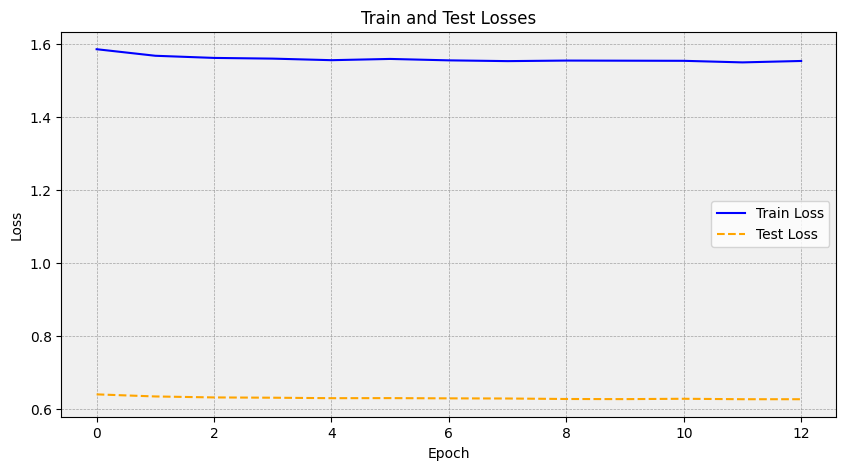

In [ ]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='-')
plt.plot(test_losses, label='Test Loss', color='orange', linestyle='--')
plt.title('Train and Test Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='gray')
plt.gca().set_facecolor('#f0f0f0')
plt.show()

### Part for self supervised learning model

In [ ]:
# Define transformations for training and test data
train_transforms_for_self_supervised = train_transforms_for_autoencoder
test_transforms_for_self_supervised = test_transforms_for_autoencoder

train_dataset_for_self_supervised = datasets.CIFAR10(root='cifar10', train=True, transform=train_transforms_for_self_supervised, download=True)
test_dataset_for_self_supervised = datasets.CIFAR10(root='cifar10', train=False, transform=test_transforms_for_self_supervised, download=True)

# Take 10 percent of train dataset
_, train_indices_10_percent = train_test_split(list(range(len(train_dataset_for_self_supervised))), test_size=0.1, stratify=train_dataset_for_self_supervised.targets)

# Create data loaders for training and test datasets
train_data_loader_for_self_supervised = data.DataLoader(Subset(train_dataset_for_self_supervised, train_indices_10_percent),
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=True)

test_data_loader_for_self_supervised = data.DataLoader(test_dataset_for_self_supervised,
                                   batch_size=batch_size,
                                   shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define the self supervised model
class SelfSupervisedModel(nn.Module):
    def __init__(self, encoder):
        super(SelfSupervisedModel, self).__init__()

        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=32 * 8 * 8, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=128),
            nn.Dropout(p=0.4)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=64),
            nn.Dropout(p=0.4)
        )
        self.fc3 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)  # Flatten the input for the fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)  # Using log softmax activation for output probabilities

# Create an instance of the SelfSupervisedModel and move it to the selected device
self_supervised_model = SelfSupervisedModel(autoencoder_model.encoder).to(device)
print(self_supervised_model)

SelfSupervisedModel(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
  )
  (fc2

In [ ]:
# Modified functions from Lab 10 used for train and test
def self_supervised_train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    iteration = 0

    bar = tqdm(train_loader)
    for data, target in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        # Get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        iteration += 1

        bar.set_postfix({"Loss": format(epoch_loss/iteration, '.6f')})

    acc = 100. * correct / len(train_loader.dataset)
    print(f'\nTrain Epoch: {epoch}, elapsed time:{time()-start_time:.2f}s')
    return epoch_loss / len(train_loader.dataset), acc


def self_supervised_test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(test_loader.dataset)
    return test_loss / len(test_loader.dataset), acc

In [ ]:
# Modified function from Lab 10 used for training
def self_supervised_training(model, train_data_loader, test_data_loader, epochs, criterion, optimizer, early_stopping, device, save_path, train_info_path):
    # Check if model already exists
    if save_path and os.path.exists(save_path):
        print(f"File already exists at {save_path}. Model not trained, loaded from file.")
        model_state_dict = torch.load(save_path, map_location=device)
        model.load_state_dict(model_state_dict)

        # Load training information from file
        with open(train_info_path, 'rb') as info_file:
            train_accuracies, test_accuracies, train_losses, test_losses = pickle.load(info_file)

        return train_accuracies, test_accuracies, train_losses, test_losses

    train_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = self_supervised_train(model, device, train_data_loader, criterion, optimizer, epoch)
        test_loss, test_acc = self_supervised_test(model, device, test_data_loader, criterion)
        # Terminate training if loss stopped to decrease
        if early_stopping(test_loss, model):
            print('\nEarly stopping\n')
            break
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"Training accuracy {train_acc}, test accuracy {test_acc}")
        print(f"Training loss {train_loss}, test loss {test_loss}\n")

    with open(train_info_path, 'wb') as info_file:
        pickle.dump([train_accuracies, test_accuracies, train_losses, test_losses], info_file)

    return train_accuracies, test_accuracies, train_losses, test_losses

In [ ]:
# Defining parameters for training
self_supervised_model_path = "self_supervised_model.pt"
self_supervised_train_info_path = "train_info_path_for_self_supervised.pkl"
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = Adam(self_supervised_model.parameters())
early_stopping = EarlyStopping(patience=10, delta=0.0001, path=self_supervised_model_path)

# Training model
train_accuracies, test_accuracies, train_losses, test_losses = self_supervised_training(self_supervised_model, train_data_loader_for_self_supervised, test_data_loader_for_self_supervised, epochs, criterion, optimizer, early_stopping, device, self_supervised_model_path, self_supervised_train_info_path)

100%|██████████| 78/78 [00:02<00:00, 29.97it/s, Loss=2.186435]



Train Epoch: 1, elapsed time:2.60s
Training accuracy 24.5, test accuracy 29.94
Training loss 0.03410838963985443, test loss 0.03036929758787155



100%|██████████| 78/78 [00:02<00:00, 31.02it/s, Loss=2.035989]



Train Epoch: 2, elapsed time:2.52s
Training accuracy 25.2, test accuracy 31.7
Training loss 0.03176142780780792, test loss 0.029510996568202972



100%|██████████| 78/78 [00:02<00:00, 30.85it/s, Loss=1.982996]



Train Epoch: 3, elapsed time:2.53s
EarlyStopping counter: 1 out of 10
Training accuracy 27.16, test accuracy 31.26
Training loss 0.030934744024276734, test loss 0.02943077269792557



100%|██████████| 78/78 [00:02<00:00, 30.29it/s, Loss=1.975033]



Train Epoch: 4, elapsed time:2.58s
Training accuracy 27.28, test accuracy 32.12
Training loss 0.030810519576072695, test loss 0.029169036293029787



100%|██████████| 78/78 [00:02<00:00, 27.90it/s, Loss=1.960878]



Train Epoch: 5, elapsed time:2.80s
Training accuracy 28.06, test accuracy 32.98
Training loss 0.030589703369140624, test loss 0.028998052549362184



100%|██████████| 78/78 [00:02<00:00, 31.20it/s, Loss=1.948013]



Train Epoch: 6, elapsed time:2.50s
Training accuracy 28.56, test accuracy 33.98
Training loss 0.03038900737762451, test loss 0.0287113453745842



100%|██████████| 78/78 [00:02<00:00, 29.76it/s, Loss=1.952716]



Train Epoch: 7, elapsed time:2.62s
Training accuracy 27.56, test accuracy 34.52
Training loss 0.030462376761436462, test loss 0.02842161099910736



100%|██████████| 78/78 [00:02<00:00, 31.17it/s, Loss=1.934101]



Train Epoch: 8, elapsed time:2.50s
Training accuracy 29.28, test accuracy 35.45
Training loss 0.030171982216835022, test loss 0.02827685341835022



100%|██████████| 78/78 [00:02<00:00, 31.32it/s, Loss=1.923326]



Train Epoch: 9, elapsed time:2.49s
EarlyStopping counter: 1 out of 10
Training accuracy 29.56, test accuracy 35.33
Training loss 0.03000388195514679, test loss 0.02829601527452469



100%|██████████| 78/78 [00:02<00:00, 28.16it/s, Loss=1.933792]



Train Epoch: 10, elapsed time:2.77s
EarlyStopping counter: 2 out of 10
Training accuracy 28.78, test accuracy 35.39
Training loss 0.030167155957221983, test loss 0.028467845642566682



100%|██████████| 78/78 [00:02<00:00, 30.92it/s, Loss=1.921856]



Train Epoch: 11, elapsed time:2.52s
EarlyStopping counter: 3 out of 10
Training accuracy 30.5, test accuracy 35.95
Training loss 0.02998095917701721, test loss 0.02841517790555954



100%|██████████| 78/78 [00:02<00:00, 31.26it/s, Loss=1.928308]



Train Epoch: 12, elapsed time:2.50s
EarlyStopping counter: 4 out of 10
Training accuracy 29.66, test accuracy 35.8
Training loss 0.03008160045146942, test loss 0.0282384596824646



100%|██████████| 78/78 [00:02<00:00, 31.35it/s, Loss=1.905128]



Train Epoch: 13, elapsed time:2.49s
Training accuracy 29.9, test accuracy 36.37
Training loss 0.02971999373435974, test loss 0.028013054490089416



100%|██████████| 78/78 [00:02<00:00, 31.22it/s, Loss=1.909401]



Train Epoch: 14, elapsed time:2.50s
EarlyStopping counter: 1 out of 10
Training accuracy 29.84, test accuracy 36.04
Training loss 0.029786660766601563, test loss 0.028099108612537383



100%|██████████| 78/78 [00:03<00:00, 24.19it/s, Loss=1.901746]



Train Epoch: 15, elapsed time:3.23s
Training accuracy 30.88, test accuracy 36.5
Training loss 0.02966724283695221, test loss 0.027800586092472077



100%|██████████| 78/78 [00:03<00:00, 22.72it/s, Loss=1.894705]



Train Epoch: 16, elapsed time:3.44s
EarlyStopping counter: 1 out of 10
Training accuracy 30.22, test accuracy 36.56
Training loss 0.0295574054479599, test loss 0.027746559143066406



100%|██████████| 78/78 [00:02<00:00, 31.16it/s, Loss=1.899845]



Train Epoch: 17, elapsed time:2.50s
EarlyStopping counter: 2 out of 10
Training accuracy 30.34, test accuracy 36.16
Training loss 0.029637574553489685, test loss 0.02808180342912674



100%|██████████| 78/78 [00:02<00:00, 31.24it/s, Loss=1.904728]



Train Epoch: 18, elapsed time:2.50s
EarlyStopping counter: 3 out of 10
Training accuracy 30.4, test accuracy 36.16
Training loss 0.029713760137557985, test loss 0.027906868553161622



100%|██████████| 78/78 [00:02<00:00, 31.35it/s, Loss=1.890190]



Train Epoch: 19, elapsed time:2.49s
EarlyStopping counter: 4 out of 10
Training accuracy 30.32, test accuracy 36.13
Training loss 0.02948696177005768, test loss 0.02875060430765152



100%|██████████| 78/78 [00:02<00:00, 31.13it/s, Loss=1.908844]



Train Epoch: 20, elapsed time:2.51s
EarlyStopping counter: 5 out of 10
Training accuracy 30.82, test accuracy 36.2
Training loss 0.02977796998023987, test loss 0.027987279176712038



100%|██████████| 78/78 [00:02<00:00, 29.95it/s, Loss=1.894312]



Train Epoch: 21, elapsed time:2.61s
EarlyStopping counter: 6 out of 10
Training accuracy 30.82, test accuracy 37.14
Training loss 0.02955126829147339, test loss 0.027870727825164796



100%|██████████| 78/78 [00:02<00:00, 27.54it/s, Loss=1.891139]



Train Epoch: 22, elapsed time:2.83s
EarlyStopping counter: 7 out of 10
Training accuracy 30.04, test accuracy 35.44
Training loss 0.029501763224601747, test loss 0.0295434597492218



100%|██████████| 78/78 [00:02<00:00, 31.24it/s, Loss=1.883974]



Train Epoch: 23, elapsed time:2.50s
EarlyStopping counter: 8 out of 10
Training accuracy 30.42, test accuracy 36.69
Training loss 0.029389991211891175, test loss 0.027956172728538512



100%|██████████| 78/78 [00:02<00:00, 28.02it/s, Loss=1.873440]



Train Epoch: 24, elapsed time:2.79s
EarlyStopping counter: 9 out of 10
Training accuracy 31.42, test accuracy 35.43
Training loss 0.029225661420822144, test loss 0.03302633550167084



100%|██████████| 78/78 [00:02<00:00, 31.26it/s, Loss=1.889236]



Train Epoch: 25, elapsed time:2.50s
EarlyStopping counter: 10 out of 10

Early stopping



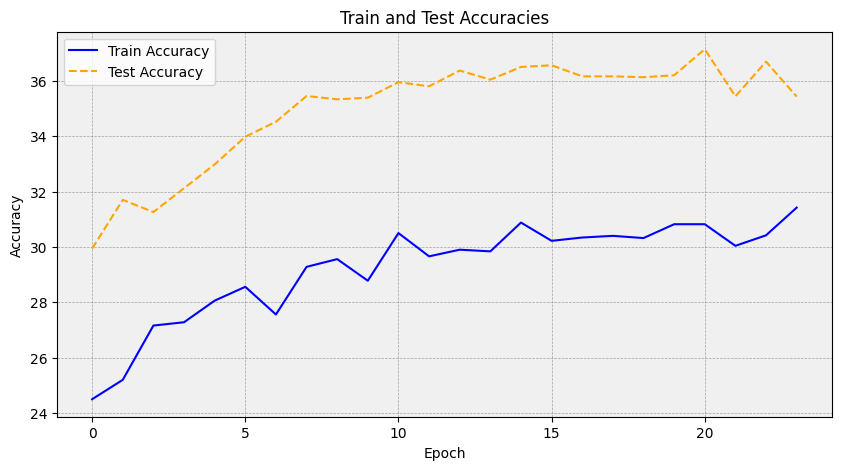

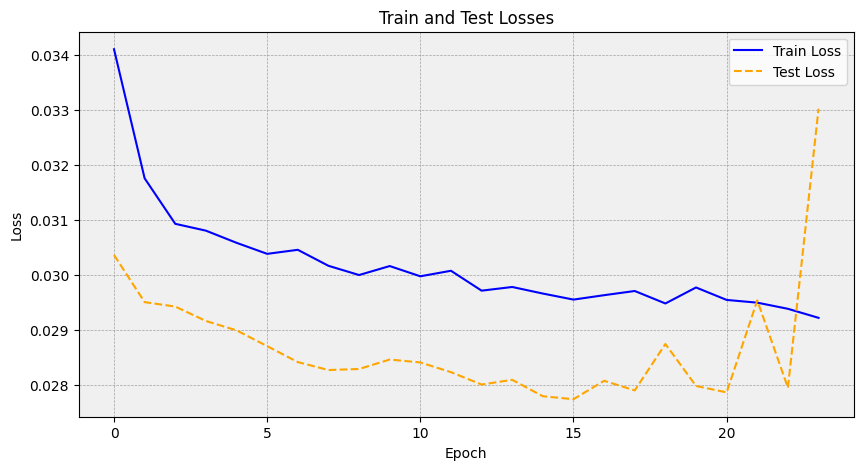

In [ ]:
# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(test_accuracies, label='Test Accuracy', color='orange', linestyle='--')
plt.title('Train and Test Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='gray')
plt.gca().set_facecolor('#f0f0f0')
plt.show()

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='-')
plt.plot(test_losses, label='Test Loss', color='orange', linestyle='--')
plt.title('Train and Test Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='gray')
plt.gca().set_facecolor('#f0f0f0')
plt.show()

In [ ]:
# Calculate loss and accuracy of the self supervised model
test_loss, accuracy = self_supervised_test(self_supervised_model, device, test_data_loader_for_self_supervised, criterion)
print(f"Test loss: {test_loss}, Accuracy: {accuracy}")

Test loss: 0.027800586092472077, Accuracy: 36.5


## Task 3. Auxiliary learning [12 pts]

In [ ]:
# Assign the same data loaders for training and test datasets as for self supervised model
train_data_loader_for_auxiliary = train_data_loader_for_self_supervised
test_data_loader_for_auxiliary = test_data_loader_for_self_supervised

In [ ]:
# Define the auxiliary learning model
class AuxiliaryLearningModel(nn.Module):
    def __init__(self):
        super(AuxiliaryLearningModel, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm2d(64),

        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=64 * 16 * 16, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.BatchNorm1d(512),

            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(256),

            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.35),
            nn.BatchNorm1d(128),

            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.BatchNorm1d(64),
            nn.Linear(in_features=64, out_features=10)
        )

    def forward(self, x):
        # Pass the input through the encoder
        encoded_x = self.encoder(x)

        # Pass the encoded features through the classifier for classification
        classification_output = self.classifier(torch.flatten(encoded_x, start_dim=1))

        # Pass the encoded features through the decoder for reconstruction
        reconstructed_x = self.decoder(encoded_x)

        return F.log_softmax(classification_output, dim=1), reconstructed_x

# Create an instance of the AuxiliaryLearningModel and move it to the selected device
auxiliary_model = AuxiliaryLearningModel().to(device)
print(auxiliary_model)

AuxiliaryLearningModel(
  (encoder): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.4, inplace=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Dropout(p=0

In [ ]:
# Modified functions from Lab 10 used for train and test
def auxiliary_train(model, device, train_loader, criterion_classification, criterion_reconstruction, optimizer, epoch):
    model.train()
    epoch_loss_classification = 0
    epoch_loss_reconstruction = 0
    epoch_loss_combined = 0
    start_time = time()
    correct = 0
    iteration = 0

    bar = tqdm(train_loader)
    for data, target in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        classification_output, reconstruction_output = model(data)

        # Calculate losses
        classification_loss = criterion_classification(classification_output, target)
        reconstruction_loss = criterion_reconstruction(reconstruction_output, data)
        combined_loss = 0.7 * classification_loss + 0.3 * reconstruction_loss

        # Backpropagation
        combined_loss.backward()
        optimizer.step()

        # Accumulate losses and correct predictions
        epoch_loss_classification += classification_loss.item()
        epoch_loss_reconstruction += reconstruction_loss.item()
        epoch_loss_combined += combined_loss.item()

        pred = classification_output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        iteration += 1

        bar.set_postfix({"Classification Loss": format(epoch_loss_classification/iteration, '.6f'),
                         "Reconstruction Loss": format(epoch_loss_reconstruction/iteration, '.6f'),
                         "Combined Loss": format(epoch_loss_combined/iteration, '.6f')})

    acc = 100. * correct / len(train_loader.dataset)
    print(f'\nTrain Epoch: {epoch}, elapsed time:{time()-start_time:.2f}s')
    epoch_loss_classification /= len(train_loader.dataset)
    epoch_loss_reconstruction /= len(train_loader.dataset)
    epoch_loss_combined /= len(train_loader.dataset)

    return epoch_loss_classification, epoch_loss_reconstruction, epoch_loss_combined, acc


def auxiliary_test(model, device, test_loader, criterion_classification, criterion_reconstruction):
    model.eval()
    test_loss_classification = 0
    test_loss_reconstruction = 0
    test_loss_combined = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            classification_output, reconstruction_output = model(data)

            # Calculate losses
            classification_loss = criterion_classification(classification_output, target)
            reconstruction_loss = criterion_reconstruction(reconstruction_output, data)
            combined_loss = 0.7 * classification_loss + 0.3 * reconstruction_loss

            # Accumulate losses and correct predictions
            test_loss_classification += classification_loss.item()
            test_loss_reconstruction += reconstruction_loss.item()
            test_loss_combined += combined_loss.item()

            pred = classification_output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average losses and accuracy
    test_loss_classification /= len(test_loader.dataset)
    test_loss_reconstruction /= len(test_loader.dataset)
    test_loss_combined /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)

    return test_loss_classification, test_loss_reconstruction, test_loss_combined, acc


In [ ]:
# Modified function from Lab 10 used for training
def auxiliary_training(model, train_data_loader, test_data_loader, epochs, criterion_classification, criterion_reconstruction, optimizer, early_stopping, device, save_path, train_info_path):

    # Check if model already exists
    if save_path and os.path.exists(save_path):
        print(f"File already exists at {save_path}. Model not trained, loaded from file.")
        model_state_dict = torch.load(save_path, map_location=device)
        model.load_state_dict(model_state_dict)

        # Load training information from file
        with open( train_info_path, 'rb') as info_file:
            train_accuracies, test_accuracies, train_losses_classification, train_losses_reconstruction, train_losses_combined, test_losses_classification, test_losses_reconstruction, test_losses_combined  = pickle.load(info_file)

        return train_accuracies, test_accuracies, train_losses_classification, train_losses_reconstruction, train_losses_combined, test_losses_classification, test_losses_reconstruction, test_losses_combined

    train_accuracies, test_accuracies, train_losses_classification, train_losses_reconstruction, train_losses_combined, test_losses_classification, test_losses_reconstruction, test_losses_combined = [], [], [], [], [], [], [], []

    for epoch in range(1, epochs + 1):
        train_loss_cl, train_loss_re, train_loss_co, train_acc = auxiliary_train(model, device, train_data_loader, criterion_classification, criterion_reconstruction, optimizer, epoch)
        test_loss_cl, test_loss_re, test_loss_co, test_acc = auxiliary_test(model, device, test_data_loader, criterion_classification, criterion_reconstruction)
        # Terminate training if loss stopped to decrease
        if early_stopping(test_loss_co, model):
            print('\nEarly stopping\n')
            break

        train_accuracies.append(train_acc)
        train_losses_classification.append(train_loss_cl)
        train_losses_reconstruction.append(train_loss_re)
        train_losses_combined.append(train_loss_co)

        test_accuracies.append(test_acc)
        test_losses_classification.append(test_loss_cl)
        test_losses_reconstruction.append(test_loss_re)
        test_losses_combined.append(test_loss_co)

        print(f"Train accuracy: {train_acc:.2f}%, Test accuracy: {test_acc:.2f}%")
        print(f"Train loss (Classification): {train_loss_cl:.4f}, Train loss (Reconstruction): {train_loss_re:.4f}, Train loss (Combined): {train_loss_co:.4f}")
        print(f"Test loss (Classification): {test_loss_cl:.4f}, Test loss (Reconstruction): {test_loss_re:.4f}, Test loss (Combined): {test_loss_co:.4f}\n")

    with open(train_info_path, 'wb') as info_file:
        pickle.dump([train_accuracies, test_accuracies, train_losses_classification, train_losses_reconstruction, train_losses_combined, test_losses_classification, test_losses_reconstruction, test_losses_combined], info_file)

    return train_accuracies, test_accuracies, train_losses_classification, train_losses_reconstruction, train_losses_combined, test_losses_classification, test_losses_reconstruction, test_losses_combined

In [ ]:
# Defining parameters for training
auxiliary_model_path = "auxiliary_model.pt"
auxiliary_train_info_path = "train_info_path_for_auxiliary.pkl"
epochs = 50
criterion_classification = nn.CrossEntropyLoss()
criterion_reconstruction = nn.MSELoss()
optimizer = Adam(auxiliary_model.parameters())
early_stopping = EarlyStopping(patience=5, path=auxiliary_model_path)

# Training model
train_accuracies, test_accuracies, train_losses_classification, train_losses_reconstruction, train_losses_combined, test_losses_classification, test_losses_reconstruction, test_losses_combined  = auxiliary_training(auxiliary_model, train_data_loader_for_auxiliary, test_data_loader_for_auxiliary, epochs, criterion_classification, criterion_reconstruction, optimizer, early_stopping, device, auxiliary_model_path, auxiliary_train_info_path)

100%|██████████| 78/78 [00:35<00:00,  2.17it/s, Classification Loss=1.734517, Reconstruction Loss=1.597146, Combined Loss=1.693305]



Train Epoch: 1, elapsed time:35.92s
Train accuracy: 37.00%, Test accuracy: 42.45%
Train loss (Classification): 0.0271, Train loss (Reconstruction): 0.0249, Train loss (Combined): 0.0264
Test loss (Classification): 0.0252, Test loss (Reconstruction): 0.0102, Test loss (Combined): 0.0207



100%|██████████| 78/78 [00:26<00:00,  2.91it/s, Classification Loss=1.701825, Reconstruction Loss=1.603606, Combined Loss=1.672359]



Train Epoch: 2, elapsed time:26.84s
EarlyStopping counter: 1 out of 5
Train accuracy: 38.48%, Test accuracy: 39.92%
Train loss (Classification): 0.0265, Train loss (Reconstruction): 0.0250, Train loss (Combined): 0.0261
Test loss (Classification): 0.0262, Test loss (Reconstruction): 0.0102, Test loss (Combined): 0.0214



100%|██████████| 78/78 [00:28<00:00,  2.73it/s, Classification Loss=1.685279, Reconstruction Loss=1.596460, Combined Loss=1.658633]



Train Epoch: 3, elapsed time:28.54s
Train accuracy: 39.00%, Test accuracy: 44.56%
Train loss (Classification): 0.0263, Train loss (Reconstruction): 0.0249, Train loss (Combined): 0.0259
Test loss (Classification): 0.0244, Test loss (Reconstruction): 0.0103, Test loss (Combined): 0.0201



100%|██████████| 78/78 [00:26<00:00,  2.96it/s, Classification Loss=1.661132, Reconstruction Loss=1.586498, Combined Loss=1.638742]



Train Epoch: 4, elapsed time:26.39s
EarlyStopping counter: 1 out of 5
Train accuracy: 39.94%, Test accuracy: 43.38%
Train loss (Classification): 0.0259, Train loss (Reconstruction): 0.0247, Train loss (Combined): 0.0256
Test loss (Classification): 0.0252, Test loss (Reconstruction): 0.0102, Test loss (Combined): 0.0207



100%|██████████| 78/78 [00:24<00:00,  3.15it/s, Classification Loss=1.664338, Reconstruction Loss=1.602070, Combined Loss=1.645658]



Train Epoch: 5, elapsed time:24.76s
Train accuracy: 39.84%, Test accuracy: 46.01%
Train loss (Classification): 0.0260, Train loss (Reconstruction): 0.0250, Train loss (Combined): 0.0257
Test loss (Classification): 0.0236, Test loss (Reconstruction): 0.0102, Test loss (Combined): 0.0196



100%|██████████| 78/78 [00:25<00:00,  3.12it/s, Classification Loss=1.665572, Reconstruction Loss=1.595846, Combined Loss=1.644654]



Train Epoch: 6, elapsed time:25.01s
EarlyStopping counter: 1 out of 5
Train accuracy: 40.66%, Test accuracy: 44.74%
Train loss (Classification): 0.0260, Train loss (Reconstruction): 0.0249, Train loss (Combined): 0.0257
Test loss (Classification): 0.0247, Test loss (Reconstruction): 0.0102, Test loss (Combined): 0.0204



100%|██████████| 78/78 [00:26<00:00,  2.91it/s, Classification Loss=1.659432, Reconstruction Loss=1.581392, Combined Loss=1.636020]



Train Epoch: 7, elapsed time:26.80s
EarlyStopping counter: 2 out of 5
Train accuracy: 40.34%, Test accuracy: 42.96%
Train loss (Classification): 0.0259, Train loss (Reconstruction): 0.0247, Train loss (Combined): 0.0255
Test loss (Classification): 0.0265, Test loss (Reconstruction): 0.0102, Test loss (Combined): 0.0216



100%|██████████| 78/78 [00:25<00:00,  3.11it/s, Classification Loss=1.658646, Reconstruction Loss=1.594461, Combined Loss=1.639391]



Train Epoch: 8, elapsed time:25.08s
EarlyStopping counter: 3 out of 5
Train accuracy: 40.48%, Test accuracy: 45.84%
Train loss (Classification): 0.0259, Train loss (Reconstruction): 0.0249, Train loss (Combined): 0.0256
Test loss (Classification): 0.0238, Test loss (Reconstruction): 0.0101, Test loss (Combined): 0.0197



100%|██████████| 78/78 [00:25<00:00,  3.10it/s, Classification Loss=1.622866, Reconstruction Loss=1.582138, Combined Loss=1.610648]



Train Epoch: 9, elapsed time:25.19s
EarlyStopping counter: 4 out of 5
Train accuracy: 41.24%, Test accuracy: 45.26%
Train loss (Classification): 0.0253, Train loss (Reconstruction): 0.0247, Train loss (Combined): 0.0251
Test loss (Classification): 0.0245, Test loss (Reconstruction): 0.0101, Test loss (Combined): 0.0202



100%|██████████| 78/78 [00:23<00:00,  3.26it/s, Classification Loss=1.670273, Reconstruction Loss=1.597933, Combined Loss=1.648571]



Train Epoch: 10, elapsed time:23.95s
EarlyStopping counter: 5 out of 5

Early stopping



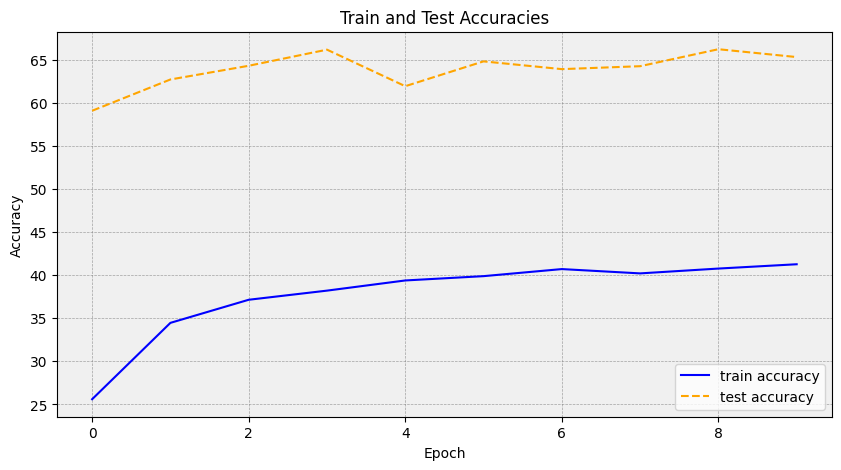

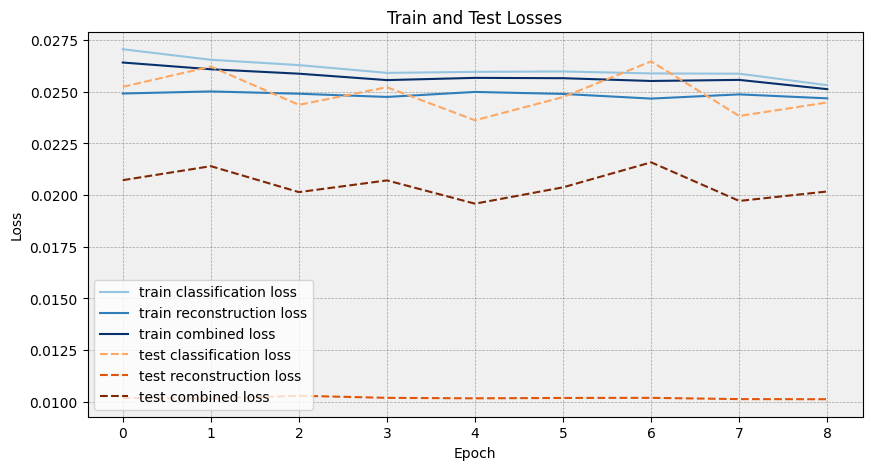

In [ ]:
# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='train accuracy', color='blue', linestyle='-')
plt.plot(test_accuracies, label='test accuracy', color='orange', linestyle='--')
plt.title('Train and Test Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='gray')
plt.gca().set_facecolor('#f0f0f0')
plt.show()

# Define beautiful colors (shades of blue for train losses and shades of orange for test losses)
train_colors = [plt.cm.Blues(i) for i in np.linspace(0.4, 1, 3)]
test_colors = [plt.cm.Oranges(i) for i in np.linspace(0.4, 1, 3)]

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses_classification, label='train classification loss', color=train_colors[0], linestyle='-')
plt.plot(train_losses_reconstruction, label='train reconstruction loss', color=train_colors[1], linestyle='-')
plt.plot(train_losses_combined, label='train combined loss', color=train_colors[2], linestyle='-')
plt.plot(test_losses_classification, label='test classification loss', color=test_colors[0], linestyle='--')
plt.plot(test_losses_reconstruction, label='test reconstruction loss', color=test_colors[1], linestyle='--')
plt.plot(test_losses_combined, label='test combined loss', color=test_colors[2], linestyle='--')
plt.title('Train and Test Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5, color='gray')
plt.gca().set_facecolor('#f0f0f0')
plt.show()


In [ ]:
test_loss_classification, test_loss_reconstruction, test_loss_combined, acc = auxiliary_test(auxiliary_model, device, test_data_loader_for_self_supervised, criterion_classification, criterion_reconstruction)
print(f"Test loss (Classification): {test_loss_classification:.4f}, Test loss (Reconstruction): {test_loss_reconstruction:.4f}, Test loss (Combined): {test_loss_combined:.4f}, Accuracy: {acc:.4f}\n")

Test loss (Classification): 0.0243, Test loss (Reconstruction): 0.0102, Test loss (Combined): 0.0201, Accuracy: 44.9900



## Task 4. Ensemble [6pts]

In [ ]:
# Define class for ensemble model
class Ensemble(nn.Module):
    def __init__(self, base_model1, base_model2, base_model3):
        super(Ensemble, self).__init__()

        # Freeze parameters of base models
        for param in base_model1.parameters():
            param.requires_grad = False
        for param in base_model2.parameters():
            param.requires_grad = False
        for param in base_model3.parameters():
            param.requires_grad = False

        self.base_model1 = base_model1
        self.base_model2 = base_model2
        self.base_model3 = base_model3

        self.final_layer = nn.Sequential(
            nn.Linear(3 * 10, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        out1 = self.base_model1(x)
        out2 = self.base_model2(x)
        out3, _ = self.base_model3(x)
        x = self.final_layer(torch.cat((out1, out2, out3), dim=1))
        return F.log_softmax(x, dim=1)

# Create an instance of the Ensemble and move it to the selected device
ensemble_model = Ensemble(custom_model, self_supervised_model, auxiliary_model).to(device)
print(ensemble_model)

Ensemble(
  (base_model1): CustomModel(
    (conv1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Dropout(p=0.1, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Dropout(p=0.15, inplace=False)
    )
    (conv3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
# Modified functions from Lab 10 used for train and test
def ensemble_train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    iteration = 0

    bar = tqdm(train_loader)
    for data, target in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        # Get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        iteration += 1

        bar.set_postfix({"Loss": format(epoch_loss/iteration, '.6f')})

    acc = 100. * correct / len(train_loader.dataset)
    print(f'\nTrain Epoch: {epoch}, elapsed time:{time()-start_time:.2f}s')
    return epoch_loss / len(train_loader.dataset), acc


def ensemble_test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(test_loader.dataset)
    return test_loss / len(test_loader.dataset), acc

In [ ]:
# Modified function from Lab 10 used for training
def ensemble_training(model, train_data_loader, test_data_loader, epochs, criterion, optimizer, early_stopping, device, save_path, train_info_path):
    # Check if model already exists
    if save_path and os.path.exists(save_path):
        print(f"File already exists at {save_path}. Model not trained, loaded from file.")
        model_state_dict = torch.load(save_path, map_location=device)
        model.load_state_dict(model_state_dict)

        # Load training information from file
        with open(train_info_path, 'rb') as info_file:
            train_accuracies, test_accuracies, train_losses, test_losses = pickle.load(info_file)

        return train_accuracies, test_accuracies, train_losses, test_losses

    train_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = ensemble_train(model, device, train_data_loader, criterion, optimizer, epoch)
        test_loss, test_acc = ensemble_test(model, device, test_data_loader, criterion)
        # Terminate training if loss stopped to decrease
        if early_stopping(test_loss, model):
            print('\nEarly stopping\n')
            break

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f"Training accuracy {train_acc}, test accuracy {test_acc}")
        print(f"Training loss {train_loss}, test loss {test_loss}\n")

    with open(train_info_path, 'wb') as info_file:
        pickle.dump([train_accuracies, test_accuracies, train_losses, test_losses], info_file)

    return train_accuracies, test_accuracies, train_losses, test_losses

In [ ]:
# Assing loaders from. self supervised model because they are the same
train_data_loader_for_ensemble = train_data_loader_for_self_supervised
test_data_loader_for_ensemble = test_data_loader_for_self_supervised

In [ ]:
# Defining parameters for training
ensemle_model_path = "ensemble_model.pt"
ensemble_train_info_path = "train_info_path_for_ensemble.pkl"
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = Adam(ensemble_model.final_layer.parameters())
early_stopping = EarlyStopping(patience=5, path=ensemle_model_path)

# Training model
train_accuracies, test_accuracies, train_losses, test_losses = ensemble_training(ensemble_model, train_data_loader_for_ensemble, test_data_loader_for_ensemble, epochs, criterion, optimizer, early_stopping, device, ensemle_model_path, ensemble_train_info_path)

100%|██████████| 78/78 [00:12<00:00,  6.01it/s, Loss=1.692021]



Train Epoch: 1, elapsed time:12.98s
Training accuracy 38.22, test accuracy 66.27
Training loss 0.02639553363323212, test loss 0.017405099892616273



100%|██████████| 78/78 [00:10<00:00,  7.36it/s, Loss=1.664838]



Train Epoch: 2, elapsed time:10.60s
EarlyStopping counter: 1 out of 5
Training accuracy 39.56, test accuracy 65.14
Training loss 0.025971469879150392, test loss 0.020055237525701524



100%|██████████| 78/78 [00:09<00:00,  8.01it/s, Loss=1.666165]



Train Epoch: 3, elapsed time:9.74s
EarlyStopping counter: 2 out of 5
Training accuracy 39.58, test accuracy 64.37
Training loss 0.025992166233062743, test loss 0.017419605952501298



100%|██████████| 78/78 [00:09<00:00,  8.01it/s, Loss=1.664259]



Train Epoch: 4, elapsed time:9.74s
Training accuracy 40.32, test accuracy 64.68
Training loss 0.02596244421005249, test loss 0.017400509440898895



100%|██████████| 78/78 [00:09<00:00,  8.00it/s, Loss=1.657037]



Train Epoch: 5, elapsed time:9.75s
EarlyStopping counter: 1 out of 5
Training accuracy 39.04, test accuracy 65.69
Training loss 0.025849778032302855, test loss 0.017422709870338438



100%|██████████| 78/78 [00:10<00:00,  7.66it/s, Loss=1.644279]



Train Epoch: 6, elapsed time:10.18s
Training accuracy 41.24, test accuracy 65.32
Training loss 0.02565075032711029, test loss 0.016693681132793427



100%|██████████| 78/78 [01:39<00:00,  1.27s/it, Loss=1.639548]



Train Epoch: 7, elapsed time:99.26s
EarlyStopping counter: 1 out of 5
Training accuracy 40.32, test accuracy 65.26
Training loss 0.02557694456577301, test loss 0.017061441427469255



100%|██████████| 78/78 [02:00<00:00,  1.54s/it, Loss=1.646908]



Train Epoch: 8, elapsed time:120.02s
EarlyStopping counter: 2 out of 5
Training accuracy 40.06, test accuracy 65.19
Training loss 0.025691762590408326, test loss 0.017555479311943054



100%|██████████| 78/78 [00:10<00:00,  7.47it/s, Loss=1.655172]



Train Epoch: 9, elapsed time:10.44s
EarlyStopping counter: 3 out of 5
Training accuracy 40.44, test accuracy 64.26
Training loss 0.025820677781105042, test loss 0.017760901015996932



100%|██████████| 78/78 [01:00<00:00,  1.29it/s, Loss=1.638931]



Train Epoch: 10, elapsed time:60.55s
EarlyStopping counter: 4 out of 5
Training accuracy 41.42, test accuracy 63.78
Training loss 0.02556732292175293, test loss 0.018304110157489777



100%|██████████| 78/78 [00:10<00:00,  7.49it/s, Loss=1.633531]



Train Epoch: 11, elapsed time:10.42s
EarlyStopping counter: 5 out of 5

Early stopping



### Evalutiating models

In [ ]:
# !pip install torchsummary
from torchsummary import summary

# Getting summary info about models
device = "cpu" # change device to avoid errors
print("Base model:")
summary(custom_model.to(device), (3, 32, 32))
print()
print("Self-supervised model:")
summary(self_supervised_model.to(device),(3, 32, 32))
print()
print("Auxiliary learning model:")
summary(auxiliary_model.to(device), (3, 32, 32))

# Summary gives error because size of ensemble model depend on other model
print()
print("Ensemble model:")
print("Ensemble model size (parameters):", sum([param.numel() for param in ensemble_model.parameters()]))

Base model:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
       BatchNorm2d-4           [-1, 16, 16, 16]              32
           Dropout-5           [-1, 16, 16, 16]               0
            Conv2d-6           [-1, 32, 16, 16]           4,640
              ReLU-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
       BatchNorm2d-9             [-1, 32, 8, 8]              64
          Dropout-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          18,496
             ReLU-12             [-1, 64, 8, 8]               0
        MaxPool2d-13             [-1, 64, 4, 4]               0
      BatchNorm2d-14       

In [ ]:
# Updated function from Assignment 2 to evaluate models
def evaluate_model(model, data_loader, auxiliary=False):
    model.eval()
    device = next(model.parameters()).device

    true_labels = []
    predicted_labels = []
    start_time = time.time()
    total_time = 0
    len_images = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            len_images += images.size(0)

            start_time = time.time()
            if auxiliary:
                outputs, _ = model(images)
            else:
                outputs = model(images)
            total_time += time.time() - start_time

            probabilities = torch.nn.functional.softmax(outputs, dim=-1)
            _, predictions = torch.max(probabilities, dim=1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())

    inference_time = total_time * 1000 / len_images

    accuracy = accuracy_score(true_labels, predicted_labels)

    result_dict = {
        "Accuracy": accuracy,
        "Inference_speed": inference_time,
    }

    return result_dict

# Evaluating models
test_data_loader = test_data_loader_for_custom
print("Base model:")
print(evaluate_model(custom_model, test_data_loader))
print()

print("Self-supervised model:")
print(evaluate_model(self_supervised_model, test_data_loader))
print()

print("Auxiliary learning model:")
print(evaluate_model(auxiliary_model, test_data_loader, auxiliary=True))
print()

print("Ensemble model:")
print(evaluate_model(ensemble_model, test_data_loader))
print()

Base model:
{'Accuracy': 0.7352, 'Inference_speed': 0.3417894124984741}

Self-supervised model:
{'Accuracy': 0.3516, 'Inference_speed': 1.0316196441650392}

Auxiliary learning model:
{'Accuracy': 0.449, 'Inference_speed': 6.592538857460022}

Ensemble model:
{'Accuracy': 0.6505, 'Inference_speed': 7.879081177711487}



## Results

| Model Type          |  Accuracy | Labeled data | Unlabeled data | Model size (params) | Inference time (ms) |
|---------------------|-------------------|--------------|----------------|---------------------|--------------------|
| Baseline            | 73.52%            | 50,000       | 0              | 496,010             | 0.3418             |
| Self-supervised     | 35.16%            | 5,000        | 50,000         | 367,850             | 1.0316             |
| Auxiliary Learning  | 44.90%            | 5,000        | 5,000          | 9,317,773           | 6.5925             |
| Ensemble            | 65.05%            | 50,000       | 50,000         | 10,194,891          | 7.8791             |


- **Baseline**: The baseline model achieves the highest accuracy with a moderate amount of labeled data (50,000) and no unlabeled data. Despite its relatively small model size, it achieves very good performance. Its fast inference time is noteworthy. This superior performance could be attributed to its training on the largest labeled dataset.

- **Self-supervised**: Despite utilizing a large amount of both unlabeled data (50,000) and labeled data (5,000), the self-supervised model achieves comparatively lower accuracy. This could be due to the lack of labeled data and not enough training of encoder part. While its model size is moderate, its inference time is higher than the baseline, suggesting some inefficiency.

- **Auxiliary learning**: The auxiliary learning model achieves moderate accuracy with a relatively small amount of both labeled and unlabeled data (5,000 each). However, it has a large model size. Additionally, its longer inference time makes it less efficient compared to the previous models.

- **Ensemble**: The ensemble model gives good accuracy. It achieves decent accuracy by leveraging models trained on substantial amounts of both labeled and unlabeled data (50,000 each), but part of ensemble model itself was trained only on a set of 5,000 labeled data. Although it has a slightly larger model size and inference time compared to the other models, it outperforms the self-supervised and auxiliary learning models in accuracy, showcasing its effectiveness in enhancing overall accuracy through pretrained models.
